In [1]:
import os
thisDir = os.path.abspath(os.curdir)
os.chdir("../../")

In [2]:
%matplotlib inline

In [5]:
import gpfanova, analysis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
data = pd.read_csv(os.path.join('data',"hsalinarum/tidy_normalize_log_st0.csv"),index_col=None)

In [7]:
data.Strain.unique()

array(['ura3', 'hlx1', 'asnC', 'trh2', 'trh3', 'trh4', 'copR', 'kaiC',
       'idr1', 'idr2', 'troR', 'phoU', 'prp2', 'birA', 'trmB', 'arcR',
       'VNG0039', 'VNG2268', 'VNG0471', 'VNG1029', 'VNG2614', 'rosR',
       'hlx2', 'cspD1', 'cspD2', 'sirR', 'VNG0194H', 'hrg', 'ura3_EV',
       'cspD1_EV', 'cspD1_cspD1', 'ura3+pMTFcmyc', 'VNG1179C+pMTFcmyc',
       'VNG1179C-VNG1179C'], dtype=object)

In [8]:
# x,y,effect,labels= analysis.data.hsalinarum_TF(standard=True,paraquat=True,osmotic=True)
# m = gpfanova.fanova.FANOVA(x,y,effect,interactions=True,parameterFile='results/hsalTF/hsalTF_interactions.csv')

In [29]:
x,y,effect,labels= analysis.data.hsalinarum_TF(standard=True,paraquat=True,osmotic=True,scaleX=False)
m = gpfanova.fanova.FANOVA(x,y,effect,interactions=True,helmertConvert=True,parameterFile='results/hsalTF/hsalTF_interactions_helmertConvert_standard-paraquat-osmotic.csv')

In [10]:
# x,y,effect,labels= analysis.data.hsalinarum_TF(standard=True,paraquat=True,osmotic=True,scaleX=False)
# m = gpfanova.fanova.FANOVA(x,y,effect,interactions=True,helmertConvert=True,parameterFile='results/hsalTF/hsalTF_interactions_standard-paraquat-osmotic.csv')

In [11]:
# x,y,effect,labels= analysis.data.hsalinarum_TF(standard=True,paraquat=True,osmotic=True)
# m = gpfanova.fanova.FANOVA(x,y,effect,interactions=True,helmertConvert=True,parameterFile='results/hsalTF/hsalTF_interactions_helmertConvert_scaleX_standard-paraquat-osmotic.csv')

In [12]:
# x,y,effect,labels= analysis.data.hsalinarum_TF(standard=True,paraquat=True,osmotic=True,mean=True)
# m = gpfanova.fanova.FANOVA(x,y,effect,interactions=True,helmertConvert=True,parameterFile='results/hsalTF/hsalTF_interactions_mean_standard-paraquat-osmotic.csv')

In [22]:
import matplotlib as mpl
import scipy
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram

def extractDelta(deltas):
    p = len(deltas.keys())
    n = deltas[deltas.keys()[0]].shape[1]
    
    a = np.zeros((p,n))
    prob = np.zeros((p,n))
    
    keys = deltas.keys()
    
    for i,k in enumerate(keys):
        samples = deltas[k]
        med = np.median(samples,0)
        samples = np.sort(samples,0)
        ns = samples.shape[0]
        lb,ub = .025*ns,.975*ns
        lb,ub = samples[[lb,ub],:]

        a[i,:] = med
        prob[i,:] = ub*lb>0 # any bounds without matching signs crosses the origin
        
        
    return keys,a,prob
    

def plot_delta(x,deltas,probability=False,cluster=False,plot_cluster=False,clusterShape=4,cluster_kwargs={},dendrogram_kwargs={},ytick_filter=lambda x: x):
    p = len(deltas.keys())
    n = x.shape[0]
    a = np.zeros((p,n))
    prob = np.zeros((p,n))
    yticks = [ytick_filter(k) for k in deltas.keys()]

    for i,k in enumerate(deltas.keys()):
        samples = deltas[k]
        med = np.median(samples,0)
        samples = np.sort(samples,0)
        ns = samples.shape[0]
        lb,ub = .025*ns,.975*ns
        lb,ub = samples[[lb,ub],:]

        a[i,:] = med
        prob[i,:] = ub*lb>0 # any bounds without matching signs crosses the origin

    if cluster:
        l = linkage(a,**cluster_kwargs)
        ind = leaves_list(l)
        a = a[ind,:]
        prob = prob[ind,:]
        yticks = [yticks[j] for j in ind]
        
        if plot_cluster:
            ax = plt.subplot2grid((1,clusterShape),(0,0),colspan=1,rowspan=1)
            dendrogram(l,no_labels=True,orientation='left',ax=ax,**dendrogram_kwargs)
            ax.set_xticks([])

    lim = np.max(np.abs(a))
    vmin = -lim
    vmax = lim

    if plot_cluster:
        ax = plt.subplot2grid((1,clusterShape),(0,1),colspan=clusterShape-1,rowspan=1)
    else:
        ax = plt.subplot2grid((1,5),(0,0),colspan=4,rowspan=1)
        
    if probability:
        # a[np.abs(prob-.5)<.475] = 0
        a[prob<1] = 0
        
    plt.imshow(a,cmap="RdBu",interpolation="none",vmin=vmin,vmax=vmax,origin='lower',aspect="auto")
    plt.yticks(range(p),yticks)
    i = np.arange(1.*n/4,n,1.*n/4)
    plt.xticks(i,[x[j].round(2) for j in i],fontsize=15)
    plt.xlabel("time (h)",fontsize=20)
    
    if plot_cluster:
#         if probability:
#             cbarAx,kwargs = mpl.colorbar.make_axes(ax)
#             cbar = mpl.colorbar.ColorbarBase(cbarAx,cmap='RdBu',ticks=[0,.5,1],**kwargs)
#             cbar.ax.set_yticklabels(['p(less\n than parent)\n>97.5%', 'no difference', 'p(greater\n than parent)\n>97.5%'],fontsize=15)
#         else:
        plt.colorbar()
    else:
        plt.colorbar()

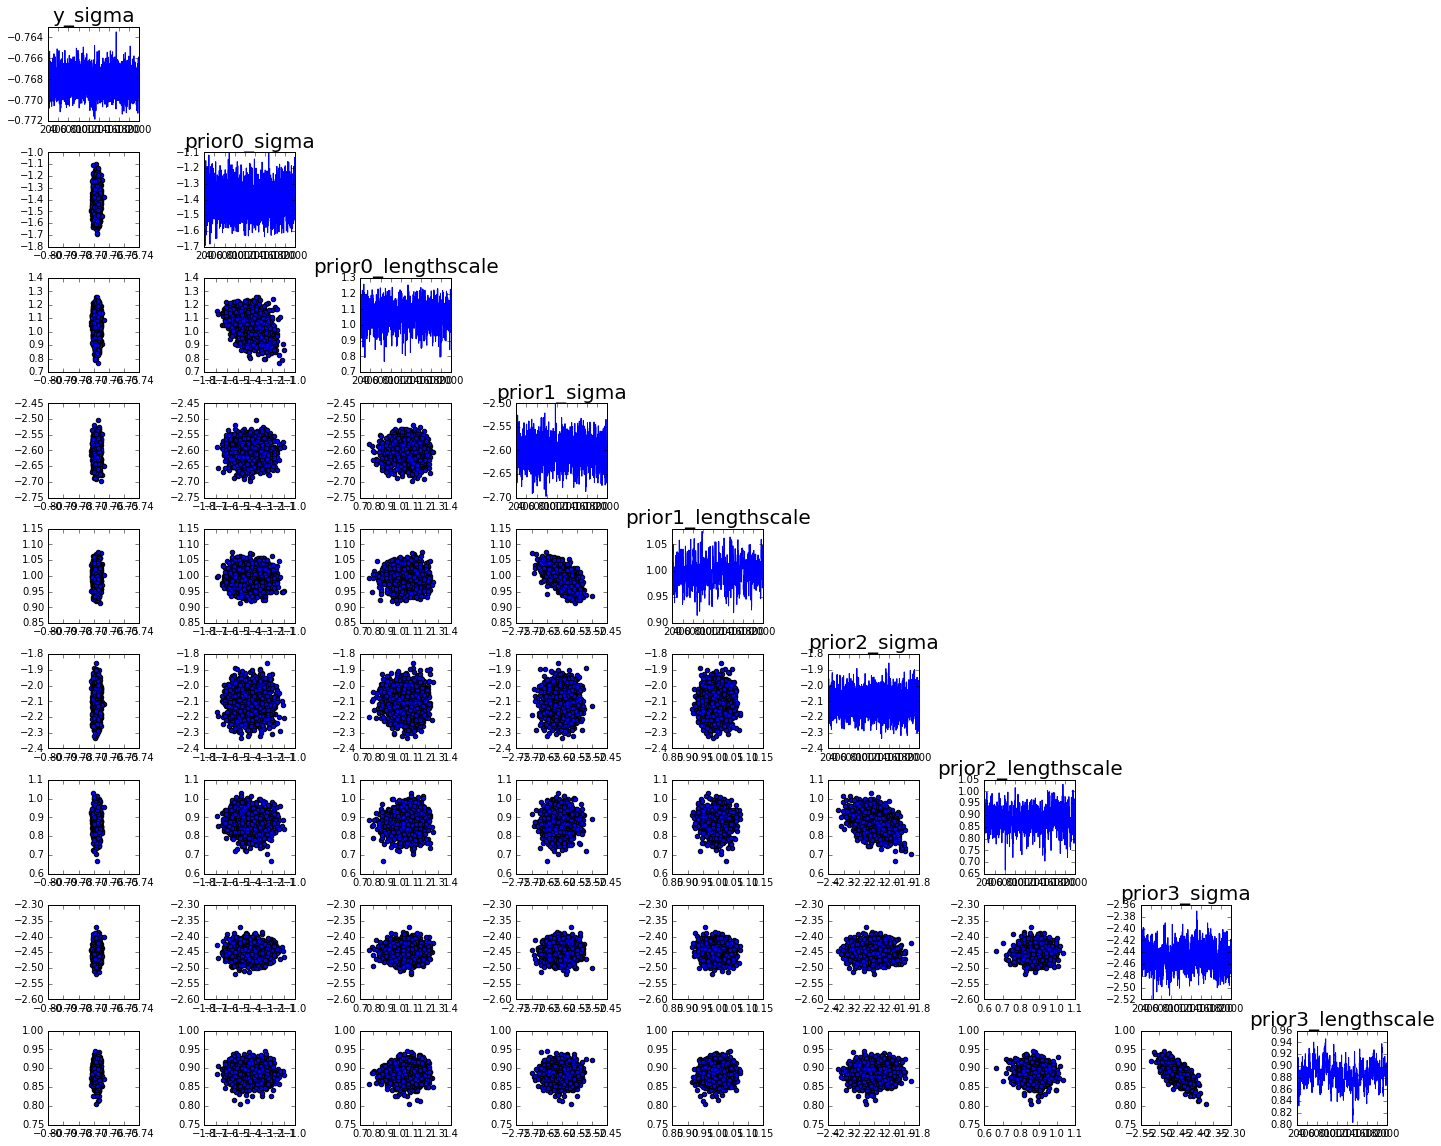

In [37]:
plt.figure(figsize=(20,16))
gpfanova.plot.plotHyperparameters(m,correlative=True,burnin=200)
plt.tight_layout(pad=1)
plt.savefig(os.path.join(thisDir,'figures','hyperparameters.png'),bbox_inches='tight',dpi=300)

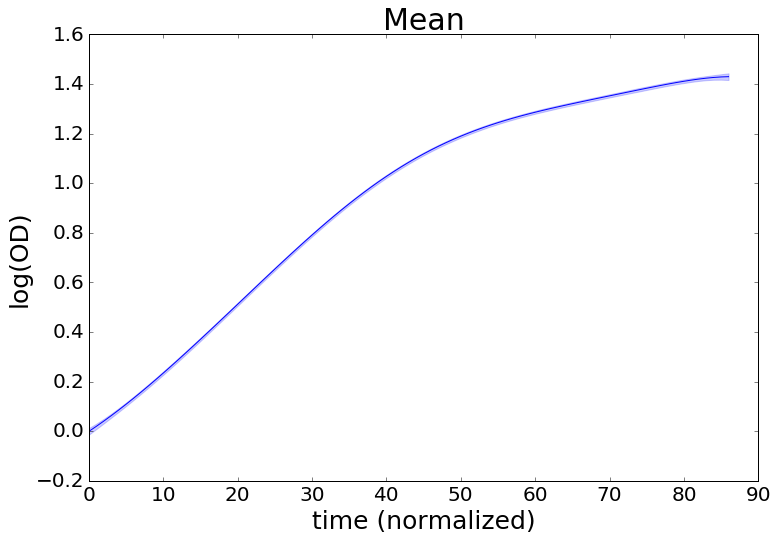

In [38]:
plt.figure(figsize=(12,8))
gpfanova.plot.plotFunctionSamples(m.parameterSamples('mean').values,)
plt.title("Mean",fontsize=30)
plt.legend(loc='best',fontsize=20)
plt.xlabel("time (normalized)",fontsize=25)
plt.ylabel("log(OD)",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig(os.path.join(thisDir,'figures','mean.png'),bbox_inches='tight',dpi=300)

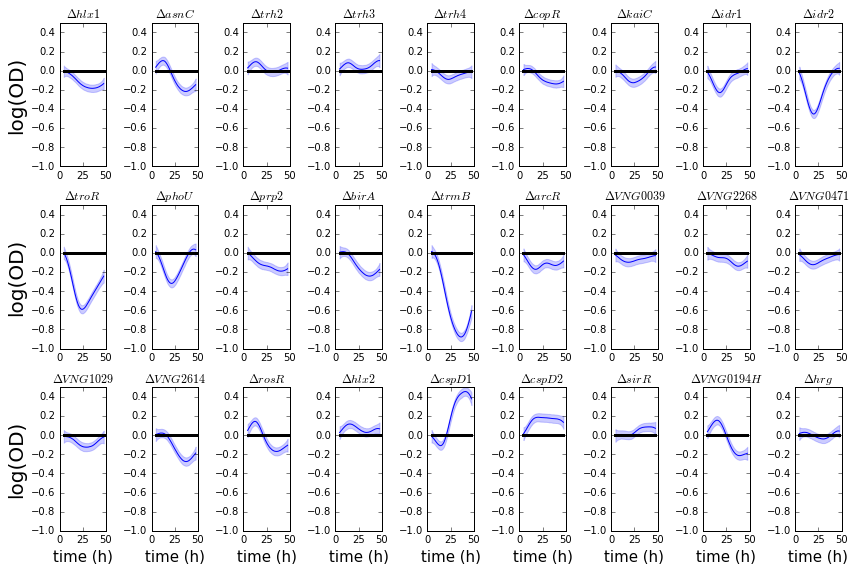

In [23]:
ura3 = m.parameterSamples('alpha_0').values + m.parameterSamples('(alpha,beta)_(0,0)').values

plt.figure(figsize=(12,8))
for i,s in enumerate(labels[1:]):
    
    plt.subplot(3,9,i+1)
    samples = m.parameterSamples('alpha_%d'%(i+1)).values + m.parameterSamples('(alpha,beta)_(%d,0)'%(i+1)).values
    gpfanova.plot.plotFunctionSamples(samples-ura3,m.x)
    plt.plot([m.x.min(),m.x.max()],[0,0],c='k',lw=3)
    plt.title(s)
    plt.ylim(-1.,.5)
    
for i in range(27):
    plt.subplot(3,9,i+1); plt.title("$\Delta "+labels[i+1]+"$");
    plt.xticks([0,25,50])
    
    if (i)%9==0:
        plt.ylabel("log(OD)",fontsize=20)
    if i+1>9*2:
        plt.xlabel("time (h)",fontsize=15)

plt.tight_layout()
plt.savefig(os.path.join(thisDir,'figures','standard-alt.pdf'),bbox_inches='tight',dpi=300)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:75: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


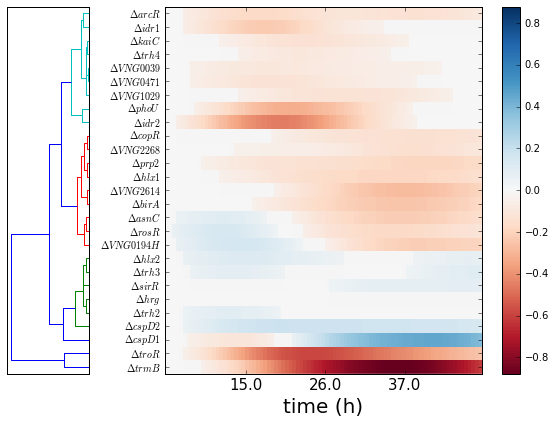

In [30]:
oddeltas = {}
ura3 = m.parameterSamples('alpha_0').values + m.parameterSamples('(alpha,beta)_(0,0)').values

for i,s in enumerate(labels[1:]):
        
    samples = m.parameterSamples('alpha_%d'%(i+1)).values + m.parameterSamples('(alpha,beta)_(%d,0)'%(i+1)).values
    oddeltas[s] = samples-ura3
    
keys,med,prob = extractDelta(oddeltas)
pd.DataFrame(med,index=keys,columns=m.x[:,0]).to_csv(os.path.join(thisDir,'standard_med.csv'))
pd.DataFrame(prob,index=keys,columns=m.x[:,0]).to_csv(os.path.join(thisDir,'standard_prob.csv'))
    
plt.figure(figsize=(8,6))
plot_delta(m.x[:,0],oddeltas,
            cluster=True,probability=True,plot_cluster=True,
            cluster_kwargs={"method":'complete'},dendrogram_kwargs={'color_threshold':2},
            ytick_filter=lambda x: '$\Delta '+x+'$')

plt.tight_layout()
plt.savefig(os.path.join(thisDir,'figures','standard-heatmap.pdf'),bbox_inches='tight',dpi=300)

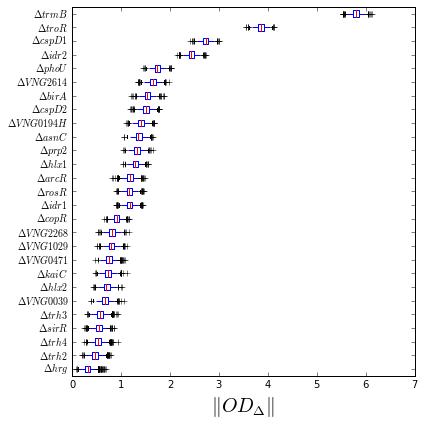

In [77]:
ura3 = m.parameterSamples('alpha_0').values + m.parameterSamples('(alpha,beta)_(0,0)').values

oddeltas = {}

plt.figure(figsize=(6,6))
for i,s in enumerate(labels[1:]):
        
    samples = m.parameterSamples('alpha_%d'%(i+1)).values + m.parameterSamples('(alpha,beta)_(%d,0)'%(i+1)).values
    oddeltas[s] = np.power(np.power(samples-ura3,2).sum(1),.5)

keys = oddeltas.keys()
oddeltaMeans = np.array([oddeltas[k].mean() for k in keys])
index = np.argsort(oddeltaMeans)
oddeltasSorted = np.array([oddeltas[k] for k in [oddeltas.keys()[i] for i in index]])
labelsSort = ["$\Delta "+s+"$" for s in keys]
labelsSort = [labelsSort[i] for i in index]
plt.boxplot(oddeltasSorted.T,vert=False,labels=labelsSort);
# plt.xscale('log')
plt.xlabel("$\|OD_\Delta\|$",fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(thisDir,'figures','standard-oddeltaNorm.pdf'),bbox_inches='tight',dpi=300)

# Paraquat 

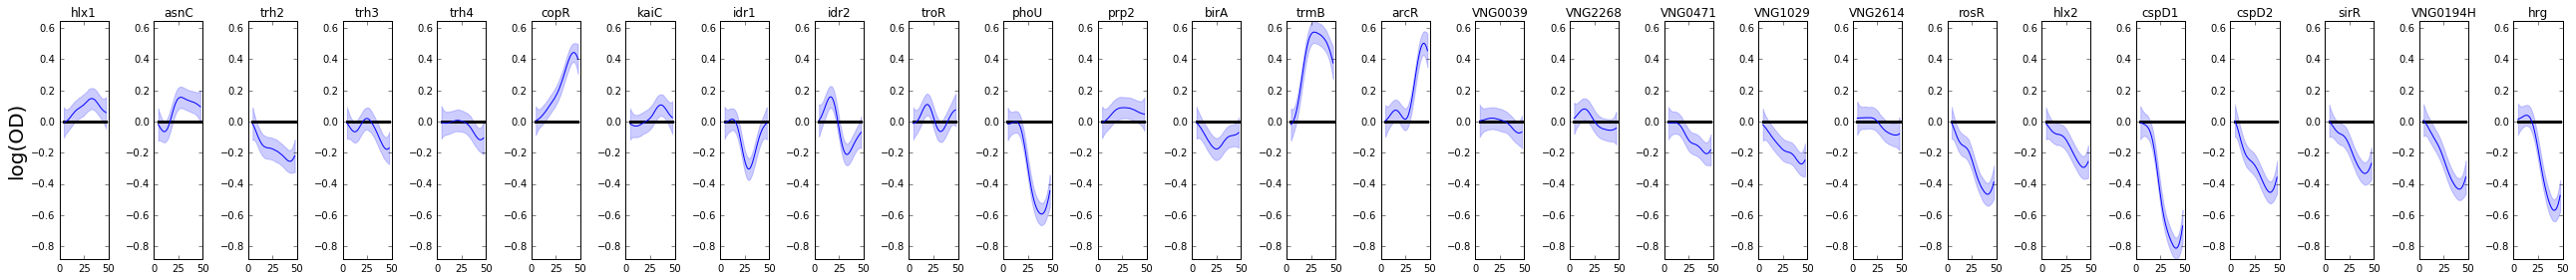

In [9]:
# plt.figure(figsize=(12,6))
# gpfanova.plot.plotInteraction(m,0,1,0,function=True,origin=True,relative=True,controlFixed=True,subplots=(3,9));
plt.figure(figsize=(36,4))
gpfanova.plot.plotInteraction(m,0,1,1,function=True,origin=True,relative=True,controlFixed=True,subplots=(1,27),color='b');

for i in range(27):
    # plt.subplot(3,9,i+1); plt.title(labels[i+1]);
    plt.subplot(1,27,i+1); plt.title(labels[i+1]);
    plt.xticks([0,25,50])
    
plt.subplot(1,27,1)
plt.ylabel("log(OD)",fontsize=20)

# plt.subplot(1,27,27/2)
# plt.xlabel("time (h)",fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(thisDir,'figures','paraquat.pdf'),bbox_inches='tight',dpi=300)

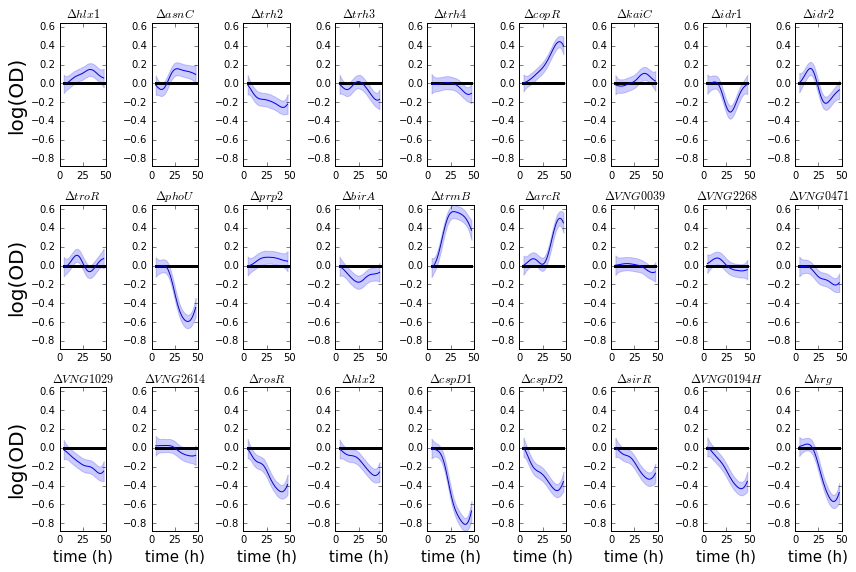

In [69]:
plt.figure(figsize=(12,8))
gpfanova.plot.plotInteraction(m,0,1,1,function=True,origin=True,relative=True,controlFixed=True,subplots=(3,9),color='b');

for i in range(27):
    plt.subplot(3,9,i+1); plt.title("$\Delta "+labels[i+1]+"$");
    plt.xticks([0,25,50])
    
    if (i)%9==0:
        plt.ylabel("log(OD)",fontsize=20)
    if i+1>9*2:
        plt.xlabel("time (h)",fontsize=15)


plt.tight_layout()
plt.savefig(os.path.join(thisDir,'figures','paraquat-alt.pdf'),bbox_inches='tight',dpi=300)

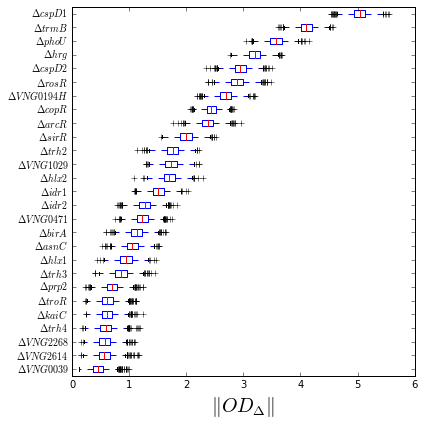

In [31]:
ura3 = m.parameterSamples('(alpha,beta)_(0,1)').values - m.parameterSamples('(alpha,beta)_(0,0)').values

oddeltas = {}

plt.figure(figsize=(6,6))
for i,s in enumerate(labels[1:]):
        
    samples = m.parameterSamples('(alpha,beta)_(%d,1)'%(i+1)).values - m.parameterSamples('(alpha,beta)_(%d,0)'%(i+1)).values
    oddeltas[s] = np.power(np.power(samples-ura3,2).sum(1),.5)

keys = oddeltas.keys()
oddeltaMeans = np.array([oddeltas[k].mean() for k in keys])
index = np.argsort(oddeltaMeans)
oddeltasSorted = np.array([oddeltas[k] for k in [oddeltas.keys()[i] for i in index]])
labelsSort = ["$\Delta "+s+"$" for s in keys]
labelsSort = [labelsSort[i] for i in index]
plt.boxplot(oddeltasSorted.T,vert=False,labels=labelsSort);
# plt.xscale('log')
plt.xlabel("$\|OD_\Delta\|$",fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(thisDir,'figures','paraquat-oddeltaNorm.pdf'),bbox_inches='tight',dpi=300)

In [36]:
oddeltas = {}
ura3 = m.parameterSamples('(alpha,beta)_(0,1)').values - m.parameterSamples('(alpha,beta)_(0,0)').values

for i,s in enumerate(labels[1:]):
        
    samples = m.parameterSamples('(alpha,beta)_(%d,1)'%(i+1)).values - m.parameterSamples('(alpha,beta)_(%d,0)'%(i+1)).values
    oddeltas[s] = samples-ura3
    
keys,med,prob = extractDelta(oddeltas)
pd.DataFrame(med,index=keys,columns=m.x[:,0]).to_csv(os.path.join(thisDir,'paraquat_med.csv'))
pd.DataFrame(prob,index=keys,columns=m.x[:,0]).to_csv(os.path.join(thisDir,'paraquat_prob.csv'))

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:51: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


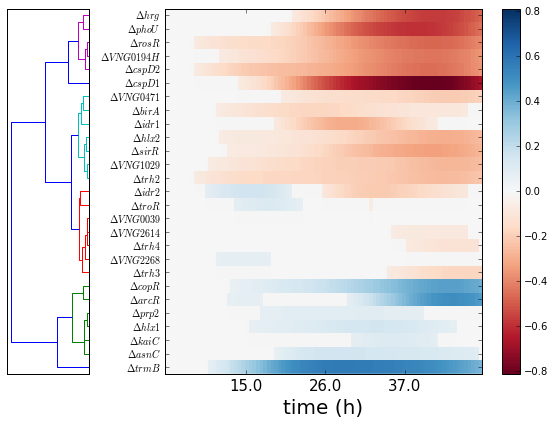

In [72]:
plt.figure(figsize=(8,6))
# plot_delta(m.x[:,0],oddeltas,cluster=True,probability=True,plot_cluster=True,ytick_filter=lambda x: '$\Delta '+x+'$')
plot_delta(m.x[:,0],oddeltas,
            cluster=True,probability=True,plot_cluster=True,
            cluster_kwargs={"method":'complete'},dendrogram_kwargs={'color_threshold':2},
            ytick_filter=lambda x: '$\Delta '+x+'$')
plt.tight_layout()
plt.savefig(os.path.join(thisDir,'figures','paraquat-heatmap.pdf'),bbox_inches='tight',dpi=300)

# Osmotic 

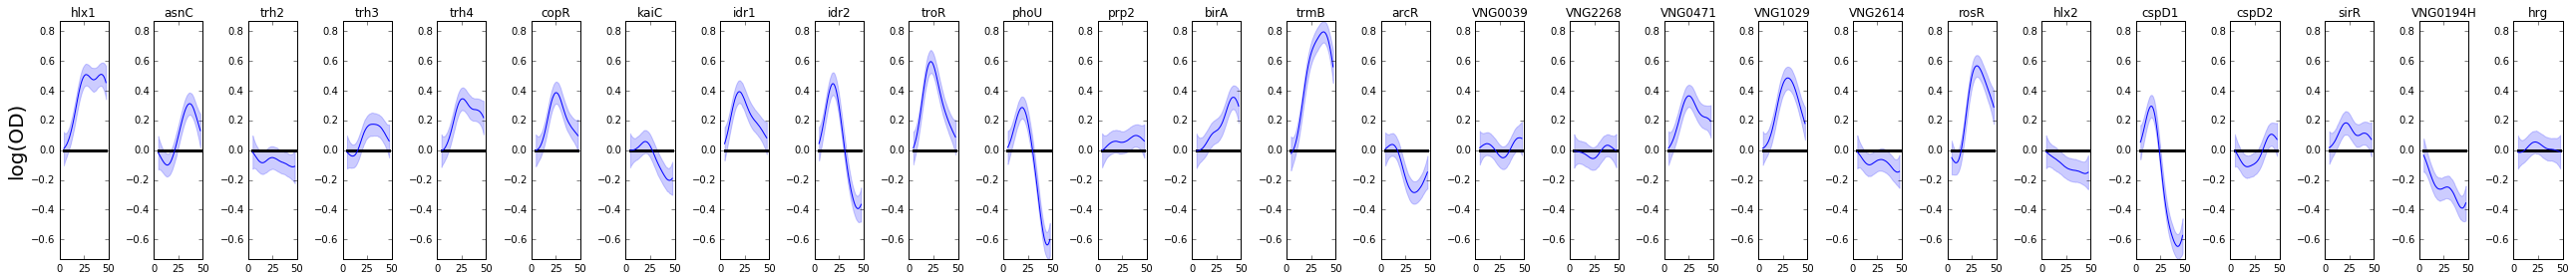

In [8]:
# plt.figure(figsize=(12,6))
# gpfanova.plot.plotInteraction(m,0,1,0,function=True,origin=True,relative=True,controlFixed=True,subplots=(3,9));
plt.figure(figsize=(36,4))
gpfanova.plot.plotInteraction(m,0,1,2,function=True,origin=True,relative=True,controlFixed=True,subplots=(1,27),color='b');

for i in range(27):
    # plt.subplot(3,9,i+1); plt.title(labels[i+1]);
    plt.subplot(1,27,i+1); plt.title(labels[i+1]);
    plt.xticks([0,25,50])
    
plt.subplot(1,27,1)
plt.ylabel("log(OD)",fontsize=20)
    
plt.tight_layout()
plt.savefig(os.path.join(thisDir,'figures','osmotic.pdf'),bbox_inches='tight',dpi=300)

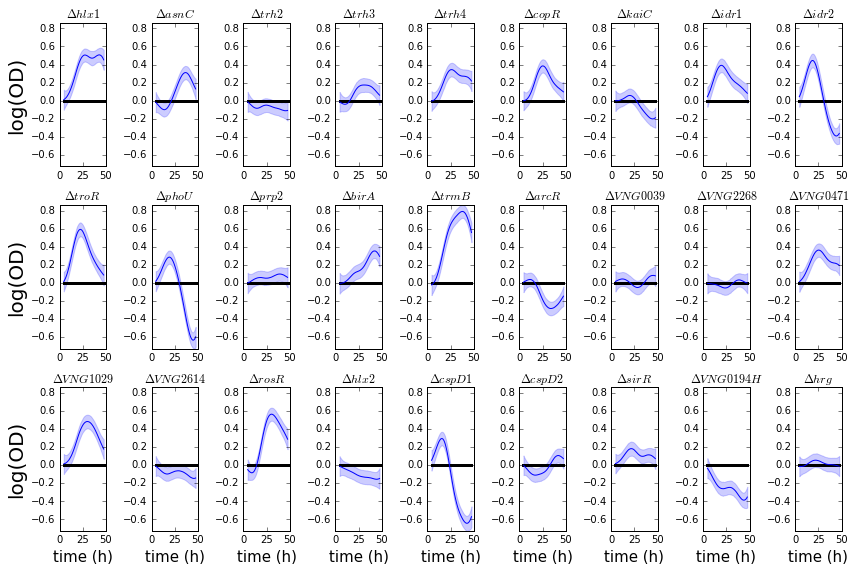

In [24]:
plt.figure(figsize=(12,8))
gpfanova.plot.plotInteraction(m,0,1,2,function=True,origin=True,relative=True,controlFixed=True,subplots=(3,9),color='b');

for i in range(27):
    plt.subplot(3,9,i+1); plt.title("$\Delta "+labels[i+1]+"$");
    plt.xticks([0,25,50])
    
    if (i)%9==0:
        plt.ylabel("log(OD)",fontsize=20)
    if i+1>9*2:
        plt.xlabel("time (h)",fontsize=15)


plt.tight_layout()
plt.savefig(os.path.join(thisDir,'figures','osmotic-alt.pdf'),bbox_inches='tight',dpi=300)

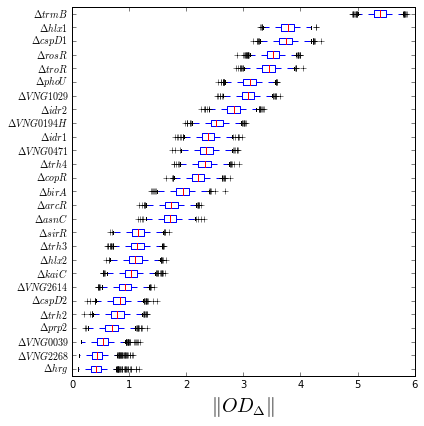

In [79]:
ura3 = m.parameterSamples('(alpha,beta)_(0,2)').values - m.parameterSamples('(alpha,beta)_(0,0)').values

oddeltas = {}

plt.figure(figsize=(6,6))
for i,s in enumerate(labels[1:]):
        
    samples = m.parameterSamples('(alpha,beta)_(%d,2)'%(i+1)).values - m.parameterSamples('(alpha,beta)_(%d,0)'%(i+1)).values
    oddeltas[s] = np.power(np.power(samples-ura3,2).sum(1),.5)

keys = oddeltas.keys()
oddeltaMeans = np.array([oddeltas[k].mean() for k in keys])
index = np.argsort(oddeltaMeans)
oddeltasSorted = np.array([oddeltas[k] for k in [oddeltas.keys()[i] for i in index]])
labelsSort = ["$\Delta "+s+"$" for s in keys]
labelsSort = [labelsSort[i] for i in index]
plt.boxplot(oddeltasSorted.T,vert=False,labels=labelsSort);
# plt.xscale('log')
plt.xlabel("$\|OD_\Delta\|$",fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(thisDir,'figures','osmotic-oddeltaNorm.pdf'),bbox_inches='tight',dpi=300)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:75: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


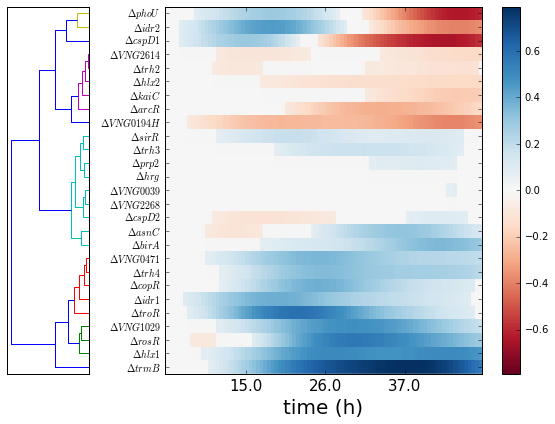

In [37]:
oddeltas = {}
ura3 = m.parameterSamples('(alpha,beta)_(0,2)').values - m.parameterSamples('(alpha,beta)_(0,0)').values

for i,s in enumerate(labels[1:]):
        
    samples = m.parameterSamples('(alpha,beta)_(%d,2)'%(i+1)).values - m.parameterSamples('(alpha,beta)_(%d,0)'%(i+1)).values
    oddeltas[s] = samples-ura3
    
keys,med,prob = extractDelta(oddeltas)
pd.DataFrame(med,index=keys,columns=m.x[:,0]).to_csv(os.path.join(thisDir,'osmotic_med.csv'))
pd.DataFrame(prob,index=keys,columns=m.x[:,0]).to_csv(os.path.join(thisDir,'osmotic_prob.csv'))
    
plt.figure(figsize=(8,6))
# plot_delta(m.x[:,0],oddeltas,cluster=True,probability=True,plot_cluster=True,ytick_filter=lambda x: '$\Delta '+x+'$')
plot_delta(m.x[:,0],oddeltas,
            cluster=True,probability=True,plot_cluster=True,
            cluster_kwargs={"method":'complete'},dendrogram_kwargs={'color_threshold':2},
            ytick_filter=lambda x: '$\Delta '+x+'$')
plt.tight_layout()
plt.savefig(os.path.join(thisDir,'figures','osmotic-heatmap.pdf'),bbox_inches='tight',dpi=300)